# Titanic Survival Prediction

## Project Overview:
The project involves building a predictive model to determine whether a passenger on the Titanic survived or not. This is a classic machine learning project that uses the Titanic dataset, which contains information about individual passengers, such as their age, gender, ticket class, fare, cabin, and whether or not they survived. The goal is to create a model that can predict passenger survival based on the available data.

## Business Problem:
The business problem is to provide a tool that can help predict the likelihood of a passenger surviving the Titanic disaster. This predictive model can be valuable for historical analysis, understanding the factors that contributed to survival, and potentially for other applications in the future.

### Project Objectives:
* Model Building: Build and train a machine learning model to predict passenger survival. Evaluate the model's performance using appropriate metrics.


# Data Understanding:
The dataset is obtained from Kaggle:[Titanic dataset](https://www.kaggle.com/datasets/brendan45774/test-file)   
The dataset contains the following columns:   
``1. PassengerId``: Unique identifier for each passenger.  
``2. Survived``: Binary variable (0 for not survived, 1 for survived).    
``3. Pclass``: Ticket class (1st, 2nd, 3rd).   
``4. Name``: Passenger's name.   
``5. Sex``: Gender of the passenger.    
``6. Age``: Age of the passenger (some missing values).   
``7. SibSp``: Number of siblings or spouses on board.  
``8. Parch``: Number of parents or children on board.  
``9. Ticket``: Ticket number.   
``10. Fare``: Passenger's fare (some missing values).   
``11. Cabin``: Cabin number (many missing values).   
``12. Embarked``: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).   


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve,roc_auc_score,log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score

In [2]:
class DataProcessor:
    def __init__(self, df):
        # Initialize with a DataFrame.
        self.df = df

    def get_info(self):
        # Get basic DataFrame info 
        return self.df.info()
    
    def get_summary_statistics(self):
        # Get summary statistics for numerical columns.
        return self.df.describe()
    
    def get_dtypes(self):
        # Get data types of columns.
        return self.df.dtypes
    
    def get_mising_values(self):
        # Get the count of missing (null) values in each column.
        return self.df.isnull().sum()
    def get_value_counts(self):
        # Get value counts for all categorical columns.
        categorical_columns = self.df.select_dtypes(include=['object']).columns
        value_counts = {}
        for col in categorical_columns:
            value_counts[col] = self.df[col].value_counts()
        return value_counts
    
    def check_duplicates_in_column(self, column_name):
        # Check for duplicate values in a specific column.
        if column_name in self.df.columns:
            duplicates = self.df[column_name][self.df[column_name].duplicated(keep=False)]
            if not duplicates.empty:
                return duplicates
            else:
                return "No duplicates found in the specified column."
        else:
            return "Column not found in the DataFrame."
        

In [3]:
#preview the dataset
df = pd.read_csv("tested.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# Initialize the DataProcessor class
dp = DataProcessor(df)

In [5]:
dp.get_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [6]:
dp.get_summary_statistics()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
dp.get_dtypes()

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
dp.get_value_counts()

{'Name': Kelly, Mr. James               1
 Carr, Miss. Jeannie            1
 Dennis, Mr. William            1
 Rosblom, Miss. Salli Helena    1
 Touma, Miss. Maria Youssef     1
                               ..
 Zakarian, Mr. Mapriededer      1
 Carlsson, Mr. Carl Robert      1
 Dintcheff, Mr. Valtcho         1
 Thomas, Mr. Charles P          1
 Peter, Master. Michael J       1
 Name: Name, Length: 418, dtype: int64,
 'Sex': male      266
 female    152
 Name: Sex, dtype: int64,
 'Ticket': PC 17608    5
 CA. 2343    4
 113503      4
 PC 17483    3
 220845      3
            ..
 349226      1
 2621        1
 4133        1
 113780      1
 2668        1
 Name: Ticket, Length: 363, dtype: int64,
 'Cabin': B57 B59 B63 B66    3
 B45                2
 C89                2
 C55 C57            2
 A34                2
                   ..
 E52                1
 D30                1
 E31                1
 C62 C64            1
 C105               1
 Name: Cabin, Length: 76, dtype: int64,
 'Embar

## Data Cleaning

Dealing with missing values

In [9]:
# chec for missing values
dp.get_mising_values()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

The cabin column has a significant amount of missing values so the column will be dropped

In [10]:
# drop the Cabin column
df = df.drop('Cabin', axis=1)

drop the row with missing values in fare and age

In [11]:
df = df.dropna(subset=['Fare', 'Age'])

In [12]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

#### Checking for duplicates
PassengerId will be used here since it is a unuque identifier

In [13]:
# check for duplicates
dp.check_duplicates_in_column('PassengerId')

'No duplicates found in the specified column.'

### check for outliers and drop them

In [14]:
numerical_columns = ['Pclass', 'Age']

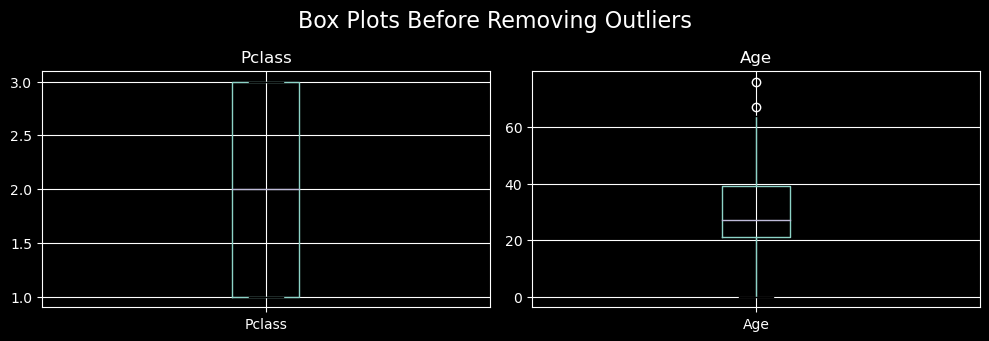

Number of rows with outliers before removal: 22


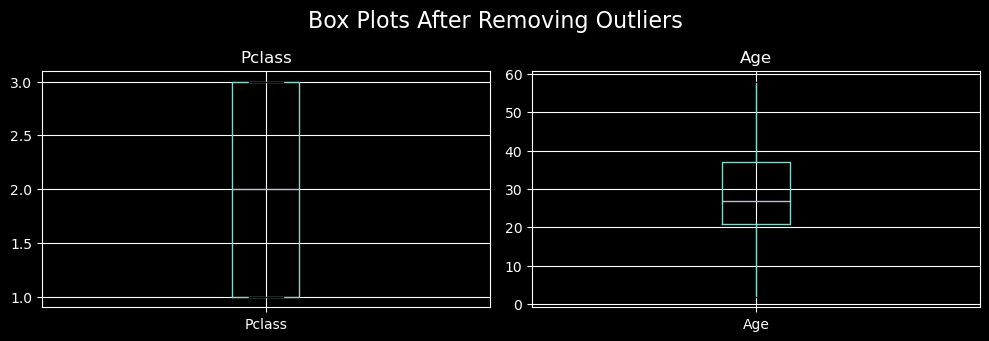

Number of rows after removing outliers: 309


In [15]:
# Set the dark_background style
plt.style.use('dark_background')

# Create box plots before removing outliers
plt.figure(figsize=(10, 6))
plt.suptitle('Box Plots Before Removing Outliers', fontsize=16)

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    df.boxplot(column=[column])
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

# Calculate z-scores for numerical columns
z_scores = pd.DataFrame()
for column in numerical_columns:
    z_scores[column] = (df[column] - df[column].mean()) / df[column].std()

# Set a z-score threshold to identify outliers (e.g., 2 or -2 for a 95% confidence interval)
z_score_threshold = 2

# Identify outliers based on z-scores
outliers = z_scores[(z_scores.abs() > z_score_threshold).any(axis=1)]

# Display the number of rows with outliers before removal
print("Number of rows with outliers before removal:", len(outliers))

# Remove outliers 
df = df[~((z_scores.abs() > z_score_threshold).any(axis=1))]

# Create box plots after removing outliers
plt.figure(figsize=(10, 6))
plt.suptitle('Box Plots After Removing Outliers', fontsize=16)

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    df.boxplot(column=[column])
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

# Display the number of rows after removing outliers
print("Number of rows after removing outliers:", len(df))


#### Drop unnecessay column
PassengerId and name is a unique identify and is no needed for the modeling part

In [16]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

## Eploratory Data Analysis

### Univariate analysis 
This is analysis of one attribute

#### survival rate 
The dependent variable is the Survive column, which represents whether the passenger survived or not

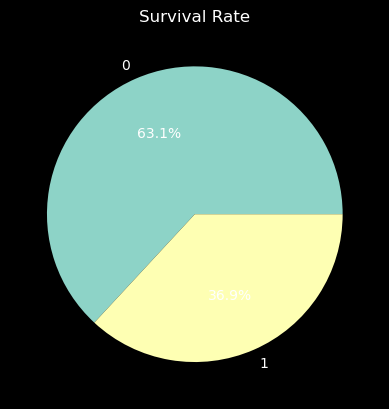

In [17]:
# Plot of Survival Rate
def plot_survival_rate(df):
    #Create a figure
    fig, ax = plt.subplots()

    # Plot the churn rate
    ax.pie(df['Survived'].value_counts(), labels=df['Survived'].value_counts().index, autopct='%1.1f%%')

    # Add a title
    ax.set_title('Survival Rate')

    # Show the plot
    plt.show()
plot_survival_rate(df)  

* $63.1$ % of people did not survive while rest   survived.

#### Distribution Plots for numerical variables

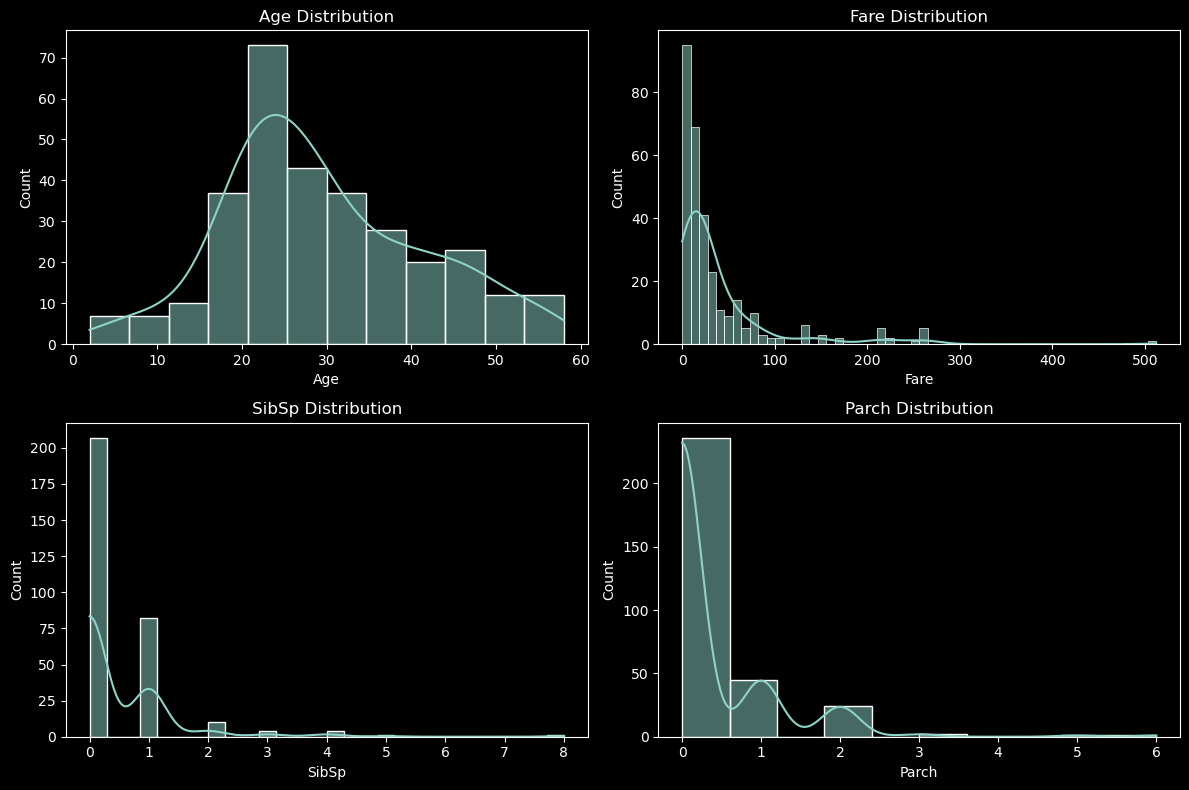

In [18]:
# Distribution plots for numerical variables
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['Age'], kde=True, ax=axes[0, 0]).set_title('Age Distribution')
sns.histplot(df['Fare'], kde=True, ax=axes[0, 1]).set_title('Fare Distribution')
sns.histplot(df['SibSp'], kde=True, ax=axes[1, 0]).set_title('SibSp Distribution')
sns.histplot(df['Parch'], kde=True, ax=axes[1, 1]).set_title('Parch Distribution')
plt.tight_layout()
plt.show()


Age Distribution: 
- The "Age" distribution plot shows that the majority of passengers appear to be adults, with a peak around ages 20-30.  

Fare Distribution:
- The "Fare" distribution plot shows that most passengers paid relatively low fares, with a peak at the lower end.
- There are a few passengers who paid significantly higher fares, leading to a long tail on the right side of the distribution.

SibSp Distribution:
- The "SibSp" distribution plot indicates that a substantial number of passengers did not have any siblings or spouses on board.

Parch Distribution:
- The "Parch" distribution plot shows that many passengers did not have parents or children on board.

#### Bar plots for categorical variables

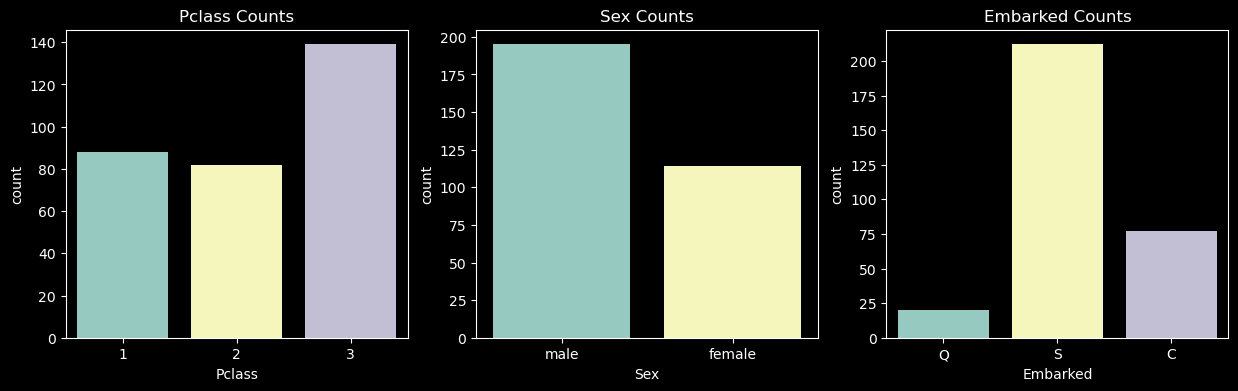

In [19]:
categorical_columns = ['Pclass', 'Sex', 'Embarked']
# Bar plots for categorical variables
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'{col} Counts')
plt.show()



Pclass Counts 
- The majority of passengers appear to be in the 3rd class, followed by the 1st class. The 2nd class has the fewest passengers
- This suggests that the Titanic had a larger number of passengers traveling in lower-class accommodations

Sex Counts
- There is a noticeable difference in the number of male and female passengers, with a significantly higher number of males

Embarked Counts
- The 'Embarked' plot illustrates the distribution of passengers by the port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).
- Most passengers embarked at Southampton (S), followed by Cherbourg (C), and a smaller number from Queenstown (Q).

## Bivariate Analysis

Bivariate analysis explores the relationships between pairs of variables.   
Let's investigate how variables interact with each other, specifically with respect to the 'Survived' variable.

#### Survivors by Passenger Class

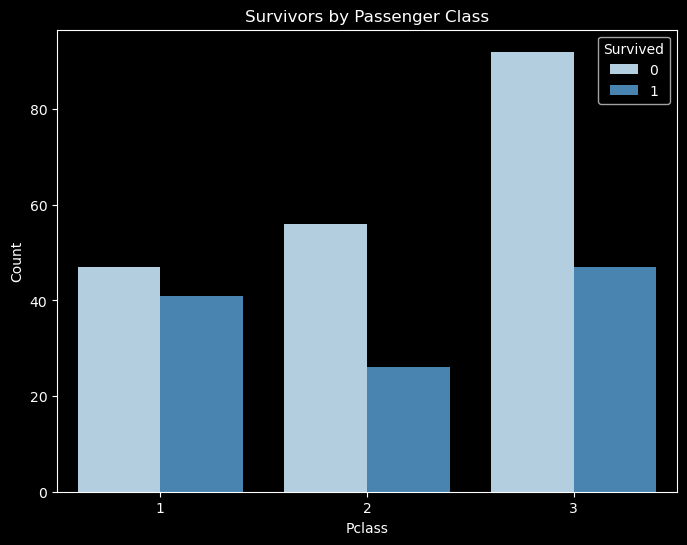

In [20]:
# Bar plot comparing the number of survivors by Pclass
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Pclass', hue='Survived', palette='Blues')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.title('Survivors by Passenger Class')
plt.show()

- in the 1st class, there is a higher number of survivors compared to non-survivors. This suggests a higher survival rate among 1st-class passengers.
- In the 2nd class, the number of survivors and non-survivors is relatively balanced.
- In the 3rd class, there are more non-survivors than survivors, indicating a lower survival rate in the 3rd class.
- This reflects the historical accounts that priority was given to higher-class passengers during the Titanic disaster

#### Correlation Heatmap between Age and Fare

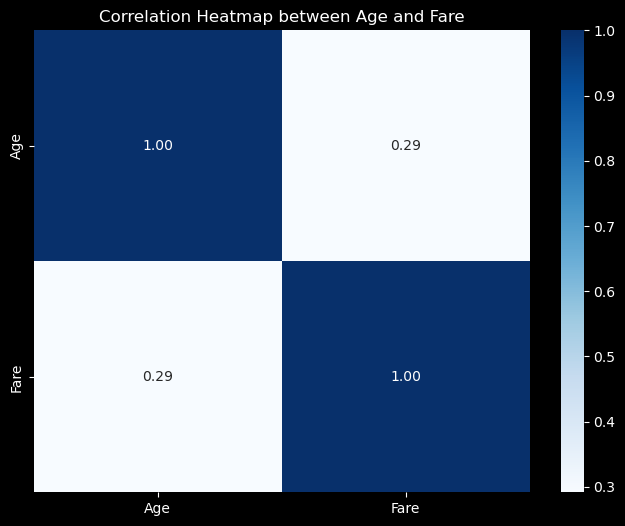

In [21]:
# Correlation heatmap between Age and Fare
correlation_matrix = df[['Age', 'Fare']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap between Age and Fare')
plt.show()

#### Correlation Heatmap between Survived and Fare

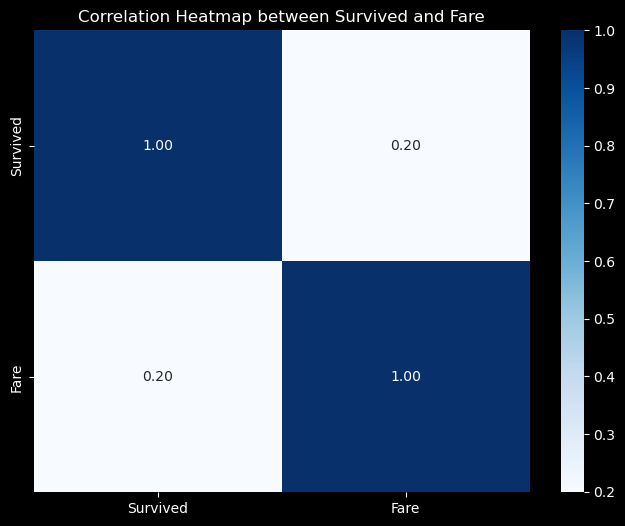

In [22]:
# Correlation heatmap between Survived' and Fare
correlation_matrix = df[['Survived', 'Fare']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap between Survived and Fare')
plt.show()

- The heatmap shows a positive correlation value, which is close to zero 
- This weak positive correlation suggests that there is a slight tendency for passengers who paid higher fares to have a slightly higher chance of survival. However, the correlation is not strong.


#### Numeric vs. Survival Analysis

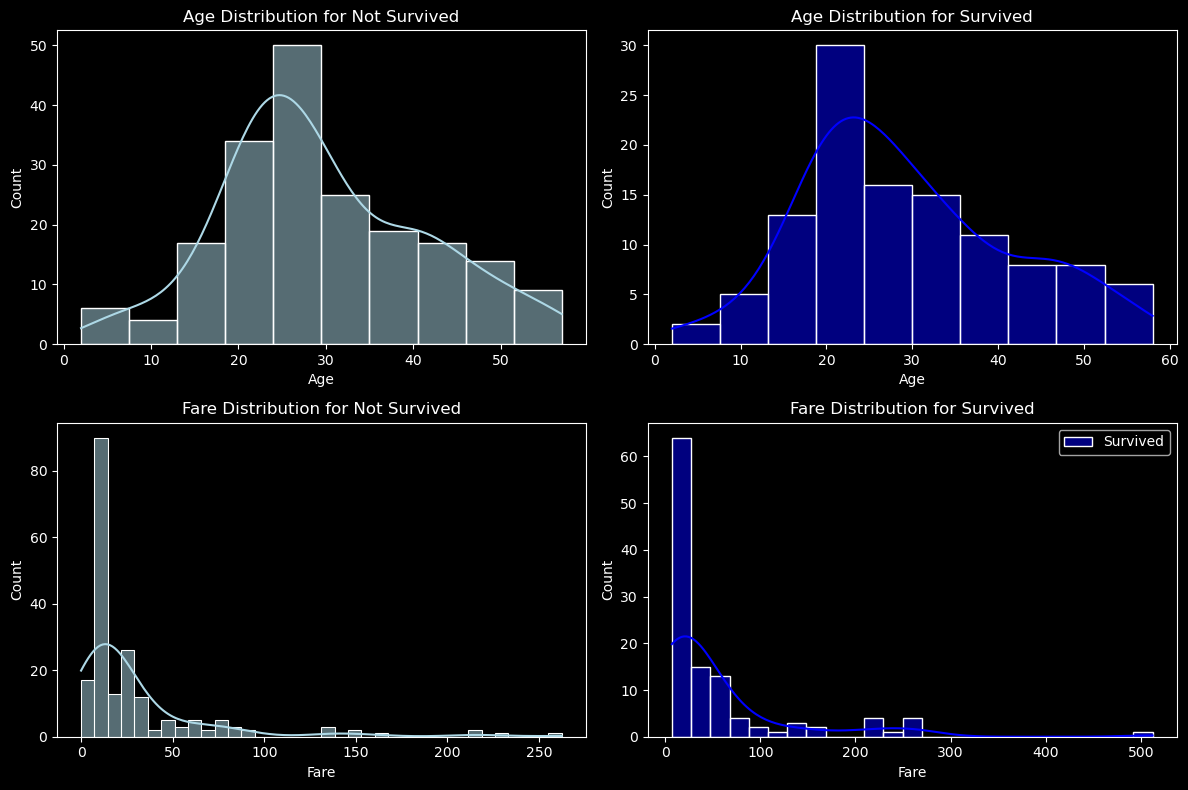

In [23]:
# Numeric vs. Survival Analysis
# Create a 2x2 grid of subplots to visualize the distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Plot the Age distribution for passengers who did not survive (Not Survived)
sns.histplot(df[df['Survived'] == 0]['Age'], kde=True, ax=axes[0, 0], color='lightblue', label='Not Survived').set_title('Age Distribution for Not Survived')
# Plot the Age distribution for passengers who survived (Survived)
sns.histplot(df[df['Survived'] == 1]['Age'], kde=True, ax=axes[0, 1], color='blue', label='Survived').set_title('Age Distribution for Survived')
# Plot the Fare distribution for passengers who did not survive (Not Survived)
sns.histplot(df[df['Survived'] == 0]['Fare'], kde=True, ax=axes[1, 0], color='lightblue', label='Not Survived').set_title('Fare Distribution for Not Survived')
# Plot the Fare distribution for passengers who survived (Survived)
sns.histplot(df[df['Survived'] == 1]['Fare'], kde=True, ax=axes[1, 1], color='blue', label='Survived').set_title('Fare Distribution for Survived')
# Add a legend
plt.legend()
# Adjust layout for a better display
plt.tight_layout()
# Show the plots
plt.show()


Age Distribution for Not Survived vs. Survived:
- The comparison suggests that a higher number of children and young adults survived compared to the "Not Survived" group.

Fare Distribution for Not Survived vs. Survived:
- The comparison suggests that passengers who paid higher fares had a better chance of survival, as there are more survivors in the higher fare range.

### Multivariate Analysis

Multivariate analysis considers the interactions of multiple variables. In this section, we'll explore relationships between multiple variables simultaneously.

#### Pair Plots


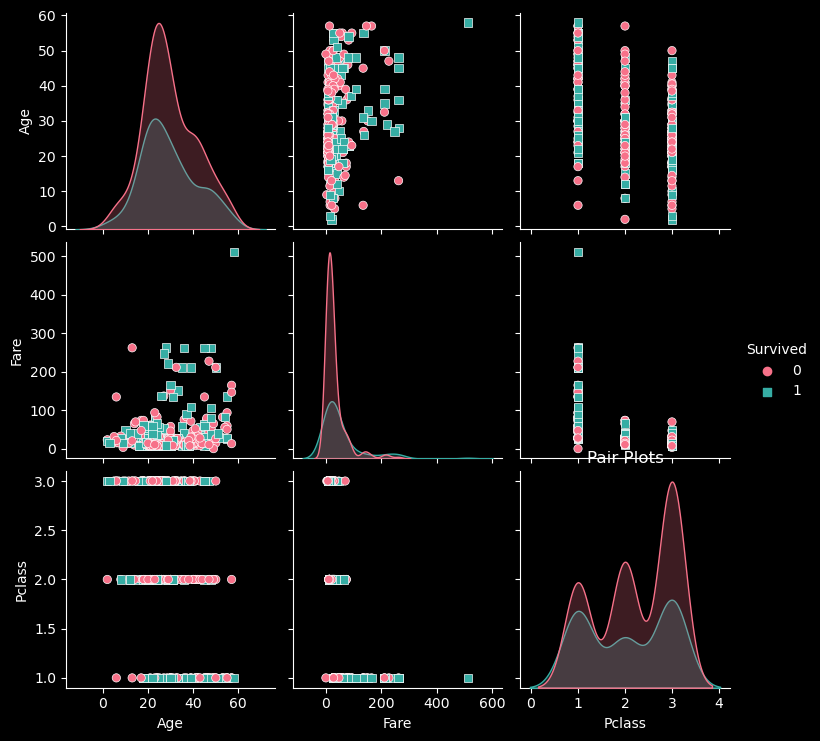

In [26]:
# Pair plots for numerical variables
sns.pairplot(df[['Age', 'Fare', 'Pclass', 'Survived']], hue='Survived', diag_kind='kde', markers=['o', 's'], palette='husl')
plt.title('Pair Plots')
plt.show()

* Age and fare distributions differ for survivors and non-survivors, with survivors tending to be younger and paying a wider range of fares.
* 1st-class passengers have a higher likelihood of survival.
* The pair plots highlight complex interactions between age, fare, and passenger class in influencing survival.

#### Correlation Heatmap

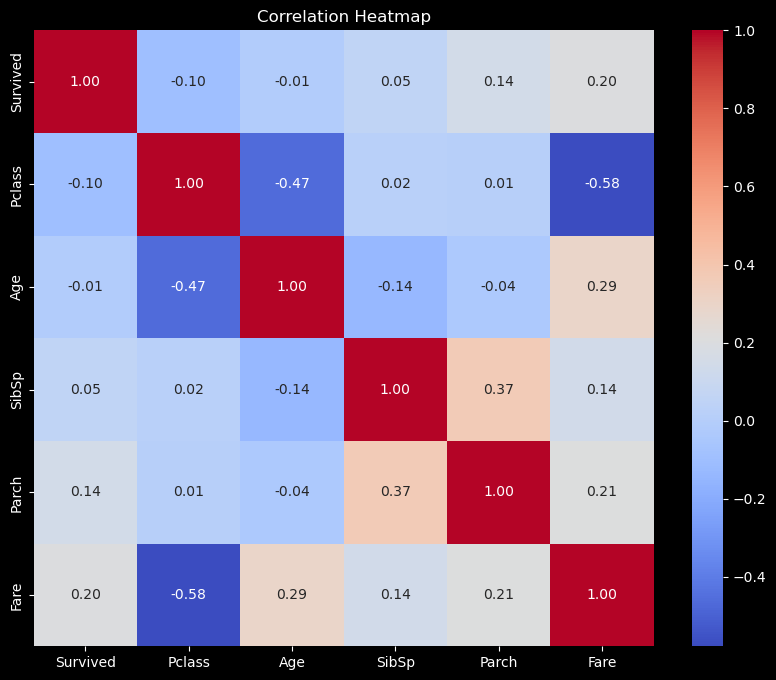

In [27]:
# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

* Weak correlation with survival, 'Pclass' negatively associated with survival, 'Fare' positively associated.
* 'Pclass' and 'Fare' negatively correlated, 'Age' and 'Pclass' negatively correlated.
* 'SibSp' and 'Parch' positively correlated, indicating family relationships.

## Data Preprocessing

### Assign the variables
assigning y/ target variable to Survived column for prediction and the rest of the features to independent variable X

In [28]:
# Assign the data to X and y
y = df['Survived'] 
X = df.drop(columns=['Survived'], axis=1)

In [29]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
5,3,male,14.0,0,0,9.2250,S


### One-Hot Encoding Categorical Variables

One-hot encoding is used to convert categorical variables into a binary format, which is suitable for machine learning algorithms. In this section, we'll one-hot encode the relevant categorical variables in our dataset.

In [30]:
# Specify the categorical columns to be one-hot encoded
categorical_columns = ['Pclass', 'Sex', 'Embarked']

# Initialize the OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
X_categorical_encoded = ohe.fit_transform(X[categorical_columns])

# Retrieve feature names for the encoded columns
feature_names = []
for i, col in enumerate(categorical_columns):
    categories = ohe.categories_[i]
    for category in categories:
        feature_names.append(f"{col}_{category}")

# Create a DataFrame for the encoded features
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=feature_names)

In [31]:
X_categorical_encoded_df.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Scaling Numerical Features  
Scaling numerical features is important to ensure that they have similar scales, which can improve the performance of machine learning models. In this section, we'll apply Z-score standardization to the selected numerical columns in our dataset.

In [32]:
# Specify the numerical columns to be scaled
numerical_columns = ['Age', 'SibSp', 'Parch', 'Fare']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numerical columns
X_numeric_scaled = scaler.fit_transform(X[numerical_columns])

# Create a DataFrame for the scaled features
X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numerical_columns)

In [33]:
X_numeric_scaled_df.head()

,Age,SibSp,Parch,Fare
0,0.427588,-0.519914,-0.465334,-0.528138
1,1.485942,0.603537,-0.465334,-0.542300
2,-0.207424,-0.519914,-0.465334,-0.513905
3,-0.630765,0.603537,0.841831,-0.451992
4,-1.308111,-0.519914,-0.465334,-0.504298


In [34]:
# combine the scaled columns and onehotencoded columns
X_final= pd.concat([X_numeric_scaled_df, X_categorical_encoded_df, ], axis=1)
X_final.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.427588,-0.519914,-0.465334,-0.528138,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.485942,0.603537,-0.465334,-0.542300,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,-0.207424,-0.519914,-0.465334,-0.513905,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,-0.630765,0.603537,0.841831,-0.451992,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,-1.308111,-0.519914,-0.465334,-0.504298,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Train-Test Split

In machine learning, it's common to split the dataset into a training set and a testing set. The training set is used to train the model, while the testing set is used to evaluate its performance. Let's split our dataset to prepare for model training.

In [35]:
# Split the dataset into a training set (80%) and a testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (247, 12)
X_test shape: (62, 12)
y_train shape: (247,)
y_test shape: (62,)


### SMOTE 

In [36]:
y.value_counts(normalize=True)

0    0.631068
1    0.368932
Name: Survived, dtype: float64

There is data imbalance  although not  severe class imbalance

SMOTE (Synthetic Minority Over-sampling Technique) s specifically designed to handle the imbalanced distribution of the target variable, where the minority class has significantly fewer samples compared to the majority class.  

Smote will be used to resolve the imbalance in the target variable above where 1 has very few samples compared to 0

In [37]:
#instantiate SMOTE 
sm = SMOTE(k_neighbors=5, random_state=42)
# fit sm on the training data
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
# print training data set before over sampling
print('Before resampling, the shape of X_train: {}'.format(X_train.shape))
print('Before resampling, the shape of y_train: {}'.format(y_train.shape)) 
# print training data set after over sampling
print('After resampling, the shape of X_train_resampled: {}'.format(X_train_resampled.shape))
print('After resampling, the shape of y_train_resampled: {}'.format(y_train_resampled.shape))
y_train_resampled.value_counts()

Before resampling, the shape of X_train: (247, 12)
Before resampling, the shape of y_train: (247,)
After resampling, the shape of X_train_resampled: (304, 12)
After resampling, the shape of y_train_resampled: (304,)


0    152
1    152
Name: Survived, dtype: int64

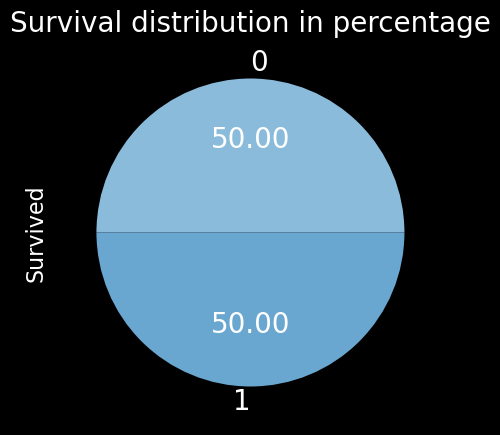

In [38]:
# Create a pie chart showing the distribution of the 'Survived' variable
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the pie chart
y_train_resampled.value_counts().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 20}, colors=custom_palette, ax=ax)

# Set labels and title
ax.set_ylabel('Survived', fontsize=16)
ax.set_title('Survival distribution in percentage', fontsize=20)

plt.show()

The data is balanced 

## Modeling

### Baseline Model - Logistic Regression 

In [39]:
# create the logistic Regression model
# Instantiate the model
logreg = LogisticRegression(solver='liblinear', C=0.1)

# Fit the model
# train the model on training data
logreg.fit(X_train_resampled, y_train_resampled)

# predict the test
y_test_pred = logreg.predict(X_test)
# Assuming you have a trained model called 'model' and test data 'X_test'
y_train_pred = logreg.predict(X_train_resampled)

#### Most important features

In [40]:
def plot_top_feature_importance(feature_importance, feature_names, top_n=10, model_name=None):
    # Sort feature importances and select the top N
    sorted_idx = np.argsort(feature_importance)[::-1][:top_n]
    pos = np.arange(sorted_idx.shape[0]) + 0.5

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(9, 6))

    # Create a horizontal bar chart
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_title(f"Top {top_n} Relative Feature Importance for {model_name}", fontsize=13, fontweight='bold')
    ax.set_yticks(pos)
    ax.set_yticklabels(np.array(feature_names)[sorted_idx], fontsize=12)

    # Adjust layout and display the chart
    plt.tight_layout()
    plt.show()

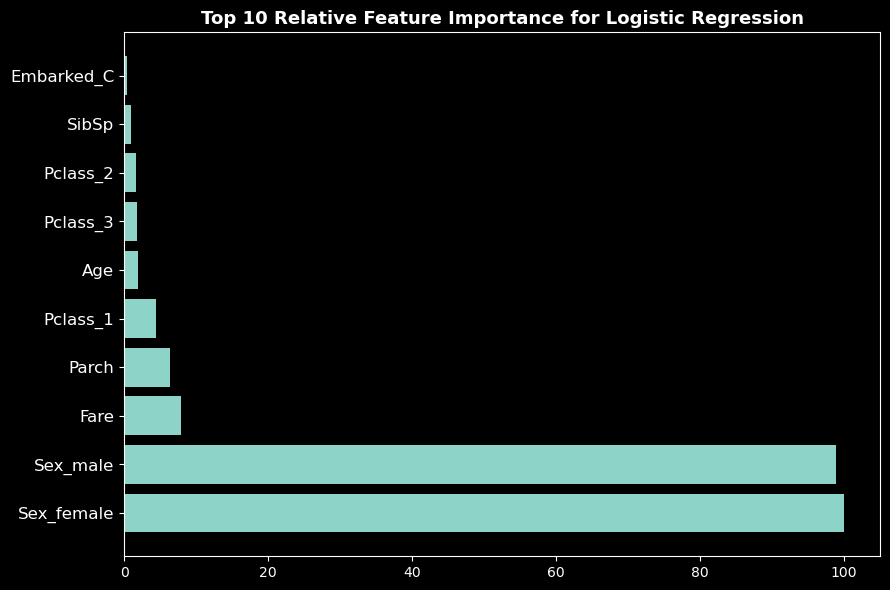

In [41]:
# Calculate the feature importances
feature_importance = abs(logreg.coef_[0])  
 # Select top 10 features
feature_importance = 100.0 * (feature_importance / feature_importance.max())[0:10] 
# Get the names of the features
feature_names = X_final.columns.tolist()
# plot
plot_top_feature_importance(feature_importance, feature_names, top_n=10, model_name='Logistic Regression')


#### Baseline Model Evaluation

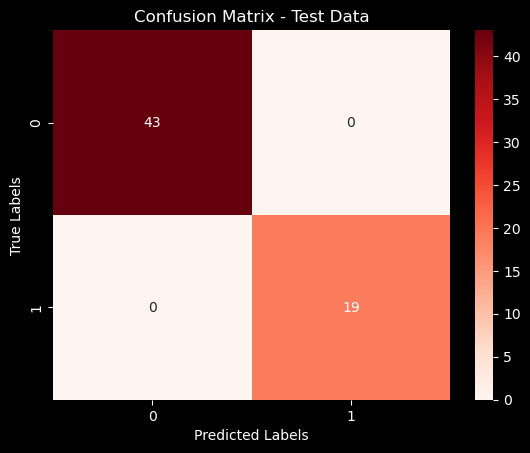

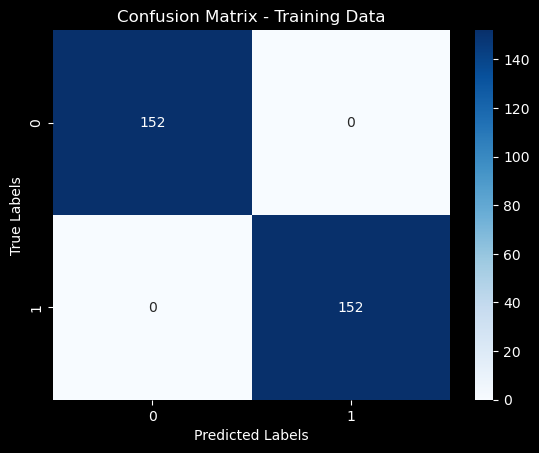

Training Data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Test Data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [42]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict the labels for the training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the evaluation metrics for training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)

    # Calculate the evaluation metrics for test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Plot the confusion matrix for test data
    sns.heatmap(test_cm, annot=True, fmt="d", cmap="Reds")
    plt.title("Confusion Matrix - Test Data")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Plot the confusion matrix for training data
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Training Data")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Print the evaluation metrics for training data
    print("Training Data:")
    print("Accuracy:", train_accuracy)
    print("Precision:", train_precision)
    print("Recall:", train_recall)
    print("F1-score:", train_f1)

    # Print the evaluation metrics for test data
    print("\nTest Data:")
    print("Accuracy:", test_accuracy)
    print("Precision:", test_precision)
    print("Recall:", test_recall)
    print("F1-score:", test_f1)
evaluate_model(logreg, X_train_resampled, y_train_resampled, X_test, y_test)

In [43]:
# Make predictions on the test data
y_pred_proba = logreg.predict_proba(X_test)

# Compute the log loss
logloss = log_loss(y_test, y_pred_proba)

print('Log Loss:', logloss)

Log Loss: 0.13139325145704292


### Second Model- Random Forest

In [44]:
# Create a pipeline with Random Forest classifier
# Define the steps in the pipeline
steps = [('rf', RandomForestClassifier(n_estimators=1000, random_state=42))]
# Create the pipeline
pipe = Pipeline(steps)  
# Perform k-fold cross-validation to assess model performance
cv_scores = cross_val_score(pipe, X_train_resampled, y_train_resampled, cv=5)
# Fit the pipeline to the training data
pipe.fit(X_train_resampled, y_train_resampled)
# Make predictions on the test set
y_test_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train_resampled)

#### Most important features

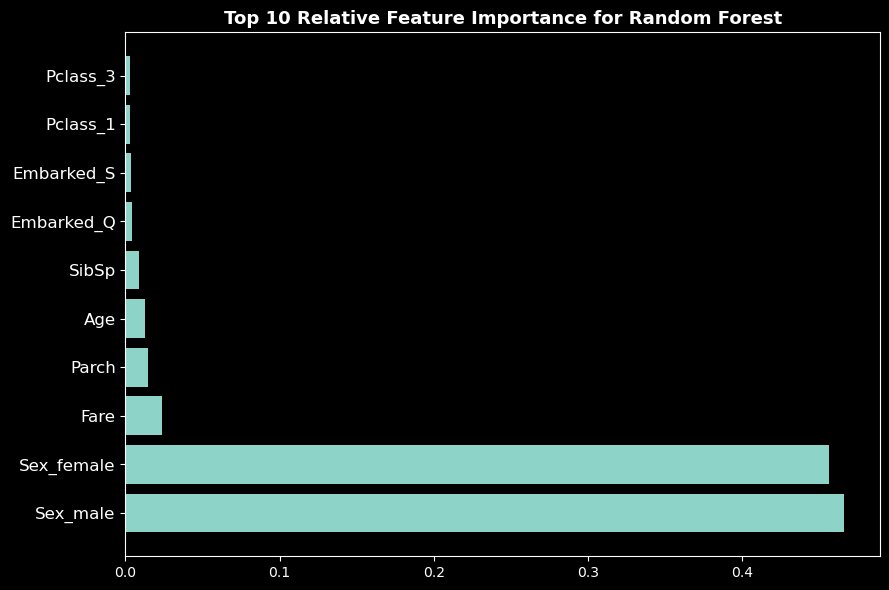

In [45]:
# Get the trained Random Forest model from the pipeline
rf_model = pipe.named_steps['rf']

# Get the feature importances from the Random Forest model
feature_importance = rf_model.feature_importances_

# Get the names of the features
feature_names = X_final.columns.tolist()

# Plot the top feature importances using the plot_top_feature_importance function
plot_top_feature_importance(feature_importance, feature_names, top_n=10, model_name='Random Forest')


#### Random forest model evaluation

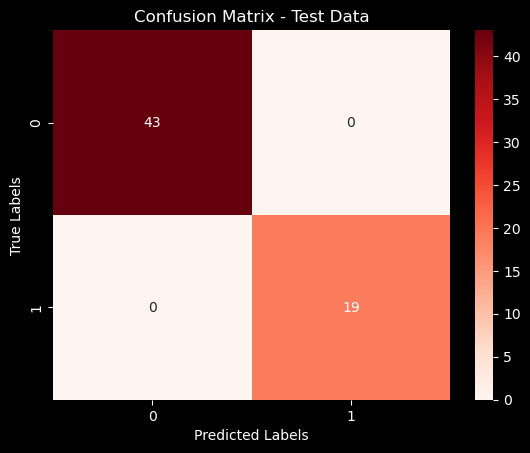

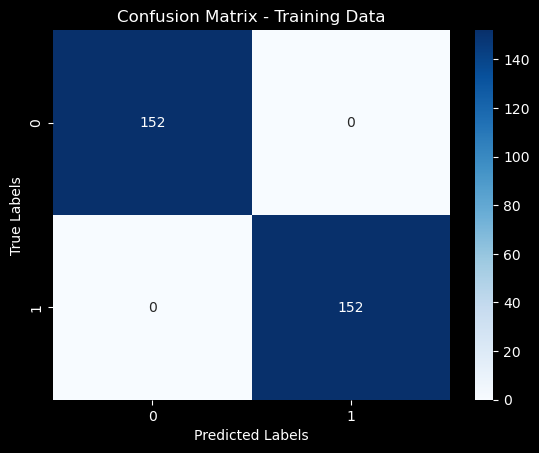

Training Data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Test Data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [46]:
# evaluate with the function defined in evaluation of baseline model
evaluate_model(pipe, X_train_resampled, y_train_resampled, X_test, y_test)

In [47]:
# Make predictions on the test data
y_pred_proba2 = pipe.predict_proba(X_test)

# Compute the log loss
logloss2 = log_loss(y_test, y_pred_proba2)

print('Log Loss:', logloss2)

Log Loss: 0.00848353426984301


## Third model - K-nearest Neighbors(KNN) Model

In [48]:
# Create an instance of KNeighborsClassifier
knn = KNeighborsClassifier()

# Fit the classifier to the training data
knn.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train_resampled)

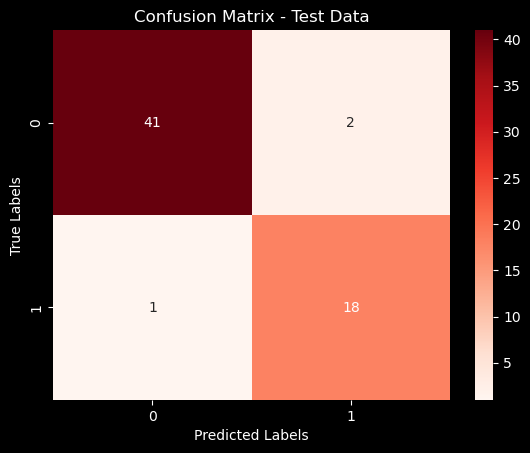

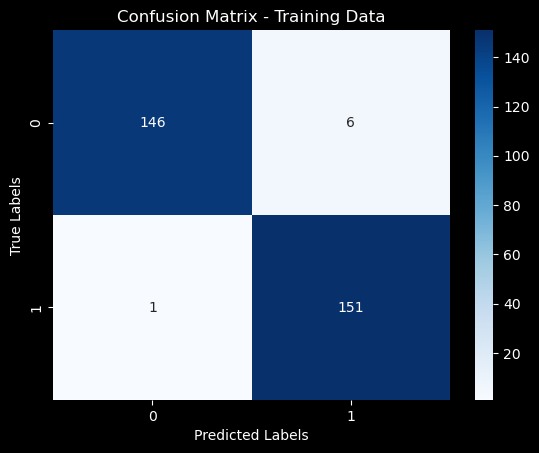

Training Data:
Accuracy: 0.9769736842105263
Precision: 0.9617834394904459
Recall: 0.993421052631579
F1-score: 0.9773462783171522

Test Data:
Accuracy: 0.9516129032258065
Precision: 0.9
Recall: 0.9473684210526315
F1-score: 0.9230769230769231


In [49]:
evaluate_model(knn, X_train_resampled, y_train_resampled, X_test, y_test)    

In [50]:
# Make predictions on the test data
y_pred_proba3 = knn.predict_proba(X_test)

# Compute the log loss
logloss3 = log_loss(y_test, y_pred_proba3)

print('Log Loss:', logloss3)

Log Loss: 0.10940905136470044


### Model comparison 
##### using ROC Curve

Logistic Regression ROC AUC: 1.0000
Random Forest ROC AUC: 1.0000
KNN ROC AUC: 0.9902


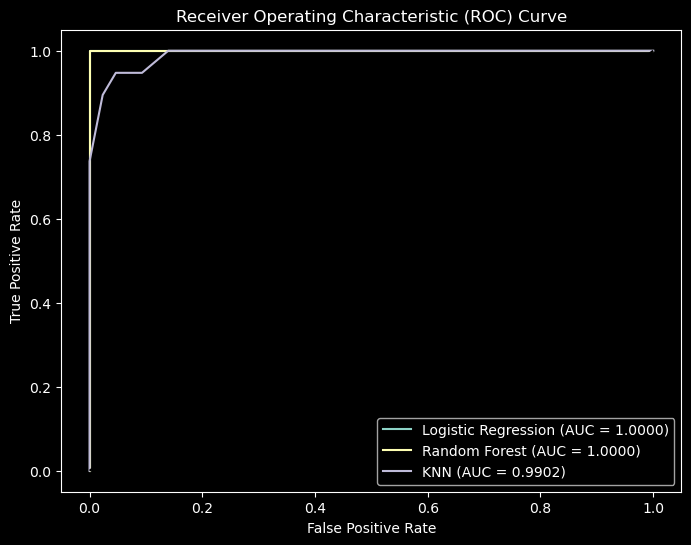

In [51]:

# models
models = [logreg, pipe, knn]
model_names = ['Logistic Regression', 'Random Forest','KNN']
# plot
plt.figure(figsize=(8, 6))

for model, name in zip(models, model_names):
    # Fit the model on training data
    model.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_proba)
    # Print ROC AUC score
    print(f'{name} ROC AUC: {auc_score:.4f}')

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Show legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

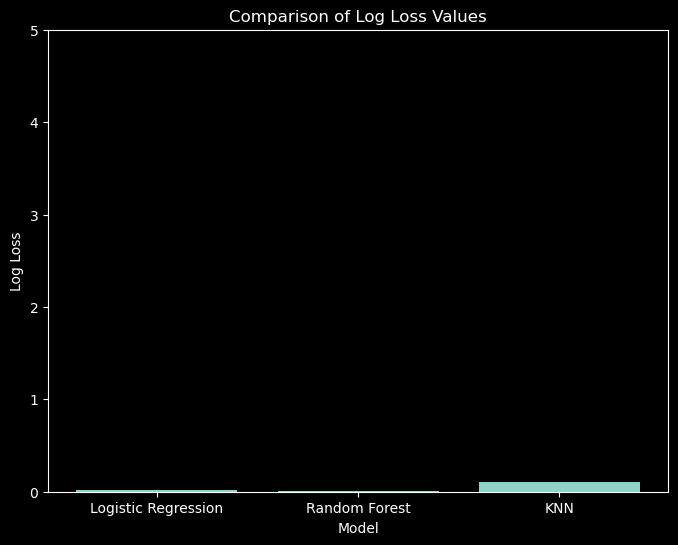

In [52]:
# Create a DataFrame to store the log loss values
logloss_data = {'Model': ['Logistic Regression', 'Random Forest', 'KNN'],
                'Log Loss': [0.02335290466574616, 0.005276222250554953, 0.1079051983170127]}
logloss_df = pd.DataFrame(logloss_data)

# Plot the log loss values
plt.figure(figsize=(8, 6))
plt.bar(logloss_df['Model'], logloss_df['Log Loss'])
plt.xlabel('Model')
plt.ylabel('Log Loss')
plt.title('Comparison of Log Loss Values')

# Set y-axis limits based on the log loss values
plt.ylim(0, 5)

plt.show()


In [53]:
param_grid = {'n_neighbors': [10, 50, 60, 70]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
best_k = grid_search.best_params_['n_neighbors']

# Create a KNN classifier with the best 'k' value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred = best_knn.predict(X_test)
y_train_pred = best_knn.predict(X_train_resampled)

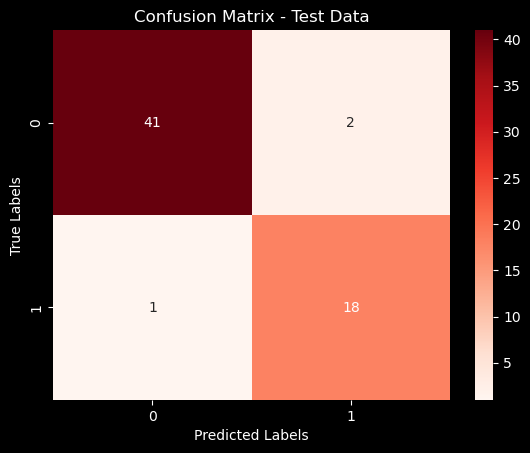

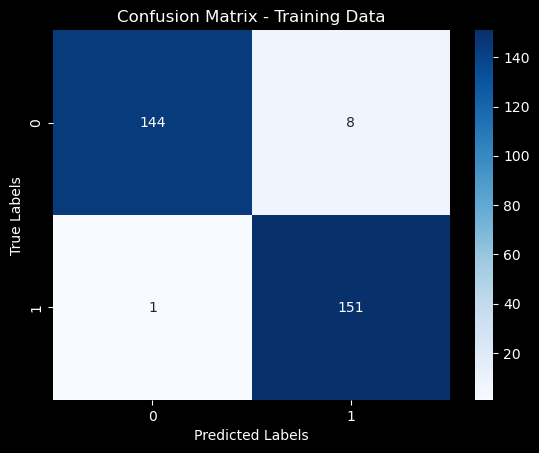

Training Data:
Accuracy: 0.9703947368421053
Precision: 0.949685534591195
Recall: 0.993421052631579
F1-score: 0.9710610932475885

Test Data:
Accuracy: 0.9516129032258065
Precision: 0.9
Recall: 0.9473684210526315
F1-score: 0.9230769230769231


In [54]:
# Evaluate the tuned logistic regression model
evaluate_model(best_knn, X_train_resampled, y_train_resampled, X_test, y_test)